In [1]:
import scanpy as sc
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import numpy as np
import gseapy as gp
from pca import pca
import h5py
import csv
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [2]:
def preprocess(adata, filter_min_counts=True, size_factors=True, normalize_input=False, logtrans_input=True):
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if filter_min_counts:
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.filter_cells(adata, min_genes=200)

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['cs_factor'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['cs_factor'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

In [3]:
def reduce_dimensions(X, reduced_dimension = 2, method = 'PCA', tsne_min = 50, match_dims = True,**kwargs):
    """
    Reduce dimensioanlity of X using dimensionality reduction method.
    """
    if X.shape[-1] > reduced_dimension:
        if method == "PCA":
            pca = PCA(n_components = reduced_dimension,**kwargs)
            pca.fit(X)
            X_pca = pca.transform(X)
            X_reduced = X_pca[:,:reduced_dimension]
            dim_name = 'PC'
        elif method == "tSNE":
            if X.shape[-1] > tsne_min:
                X,_ = reduce_dimensions(X, reduced_dimension = tsne_min, method = 'PCA')
            tsne = TSNE(n_components = reduced_dimension, init = 'pca', **kwargs)
            X_tsne = tsne.fit_transform(X)
            X_reduced = X_tsne[:,:2]
            dim_name = 't-SNE'
        elif method == 'UMAP':
            if X.shape[-1] > tsne_min:
                X,_ = reduce_dimensions(X, reduced_dimension = tsne_min, method = 'PCA')
            X_reduced = umap.UMAP(**kwargs).fit_transform(X)
            X_reduced = X_reduced[:,:2]
            dim_name = 'UMAP'
        else:
            raise Exception('{} is not a valid DR method (PCA,tSNE,UMAP)'.format(method))
    else:
        if X.shape[-1] < reduced_dimension and match_dims:
            dim_diff = reduced_dimension - X.shape[-1]
            X_reduced = np.concatenate([X, np.zeros([len(X),dim_diff])], axis = 1)
        else:
            X_reduced = X
        dim_name = "Dim"
    dim_labels = ["{} {}".format(dim_name, ii+1) for ii in range(reduced_dimension)]
    return X_reduced, dim_labels

In [4]:
def remove_spines(ax):
    ax.set_facecolor("white")
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [5]:
def add_geneset1(gene_embeddings,gene_names):

    genesets = {"scsig": "../datasets/co-expression/fetal_liver_atlas/MSigDB/scsig.all.v1.0.1.symbols.gmt",
                "Hallmark": "../datasets/co-expression/fetal_liver_atlas/MSigDB/h.all.v7.0.symbols.gmt",
                "KEGG": "../datasets/co-expression/fetal_liver_atlas/MSigDB/c2.cp.kegg.v7.0.symbols.gmt"}

    gs_dict = gp.parser.read_gmt(genesets['scsig'])

    ## Filter genesets to Aizarani liver cells
    gs_use = [k for k in gs_dict.keys() if 'AIZARANI_LIVER' in k.upper()]
    gs_dict = {gs: gs_v for gs, gs_v in gs_dict.items() if gs in gs_use}

    ## Combine genesets with similar names
    gs_name_mapping = {k: "_".join(k.split('_')[3:-1]) for k in gs_dict.keys()}
    ###gs_dict_new
    gs_dict_new = {gs: np.array([]) for gs in np.unique([v for v in gs_name_mapping.values()])}
    for gs_name, gs_name2 in gs_name_mapping.items():
        gs_dict_new[gs_name2] = np.union1d(gs_dict_new[gs_name2], gs_dict[gs_name])

    ## Set selected cell type/group
    selected_ct = ('Hepatocytes',
                   'Kupffer_Cells',
                   'NK_NKT_cells',
                   'MHC_II_pos_B')
    gs_dict_comb_subset = {k: gs_dict_new[k] for k in selected_ct}

    ## Get mutually exclusive sets
    gs_dict_excl = {}
    for gs_name, gs_genes in gs_dict_comb_subset.items():
        for gs_name2, gs_genes2 in gs_dict_new.items():
            if gs_name != gs_name2:
                gs_genes = np.setdiff1d(gs_genes, gs_genes2)
        gs_dict_excl[gs_name] = gs_genes

    X_plot, dim_labels = reduce_dimensions(gene_embeddings, method='PCA', reduced_dimension=2)
    df_plot = pd.concat([pd.DataFrame(X_plot), pd.DataFrame(gene_names)], axis=1)
    df_plot.columns = dim_labels + ["Label"]
    df_plot.index = gene_names
    df_plot['Geneset'] = 'None'
    gs_dict_in = gs_dict_excl
    for gs_, genes in gs_dict_in.items():
        df_plot['Geneset'].loc[np.isin(df_plot.index, genes)] = gs_
    df_plot = df_plot[df_plot.Geneset != 'None']
    return df_plot,dim_labels

In [6]:
def add_geneset2(gene_embeddings,gene_names):
    csv_filename = '../datasets/co-expression/Trachea/Trachea_marker.csv'
    csv_data = {}
    with open(csv_filename) as csv_file:
        csv_reader = csv.reader(csv_file)
        headers = next(csv_reader)
        for header in headers:
            csv_data[header] = []
        for row in csv_reader:
            for i, value in enumerate(row):
                if value is not None and value.strip() != "":
                    csv_data[headers[i]].append(value)
    csv_array = {key: np.array(value) for key, value in csv_data.items()}
    gs_dict_new = csv_array

    ## Set selected cell type/group
    selected_ct = ('Tuft_cells',
                   'Basal_cells',
                   'Ciliated_cells',
                   'Neuroendocrine_cells',
                   'Ionocyte_cells',
                   'Club_cells')
    gs_dict_comb_subset = {k: gs_dict_new[k] for k in selected_ct}

    ## Get mutually exclusive sets
    gs_dict_excl = {}
    for gs_name, gs_genes in gs_dict_comb_subset.items():
        for gs_name2, gs_genes2 in gs_dict_new.items():
            if gs_name != gs_name2:
                gs_genes = np.setdiff1d(gs_genes, gs_genes2)
        gs_dict_excl[gs_name] = gs_genes

    X_plot, dim_labels = reduce_dimensions(gene_embeddings, method='PCA', reduced_dimension=2)
    df_plot = pd.concat([pd.DataFrame(X_plot), pd.DataFrame(gene_names)], axis=1)
    df_plot.columns = dim_labels + ["Label"]
    df_plot.index = gene_names
    df_plot['Geneset'] = 'None'
    gs_dict_in = gs_dict_excl
    for gs_, genes in gs_dict_in.items():
        df_plot['Geneset'].loc[np.isin(df_plot.index, genes)] = gs_
    df_plot = df_plot[df_plot.Geneset != 'None']
    return df_plot, dim_labels

In [7]:
dir0 = '../'
datasets=['fetal_liver_atlas','Trachea']

In [8]:
dataset=datasets[0]
adata0 = sc.read_h5ad(os.path.join(dir0, 'datasets/co-expression/{}/sample_fetal_liver_atlas_dataset.h5ad').format(dataset))
print(adata0)
count = np.array(adata0.raw.X.todense())
adata = sc.AnnData(count)
adata.var_names = adata0.raw.var_names
adata.obs['Cell Type'] = np.array(adata0.obs['Cell.Labels'].values)
print("number of cell type:{}".format(len(np.unique(adata.obs['Cell Type']))))
adata.var['feature_types'] = adata.var_names

adata = preprocess(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]
print(adata)

add_geneset = add_geneset1

AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'Barcodes', 'Cell.Labels', 'Source Name', 'Week gestation', 'Gender', 'Individual', 'facs sorting', 'Organ', 'facs sorting value', 'batch', 'Labels', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Cell Type'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'mean', 'std'
number of cell type:7
View of AnnData object with n_obs × n_vars = 500 × 1000
    obs: 'Cell Type', 'n_genes', 'n_counts', 'cs_factor'
    var: 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [500] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[64]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


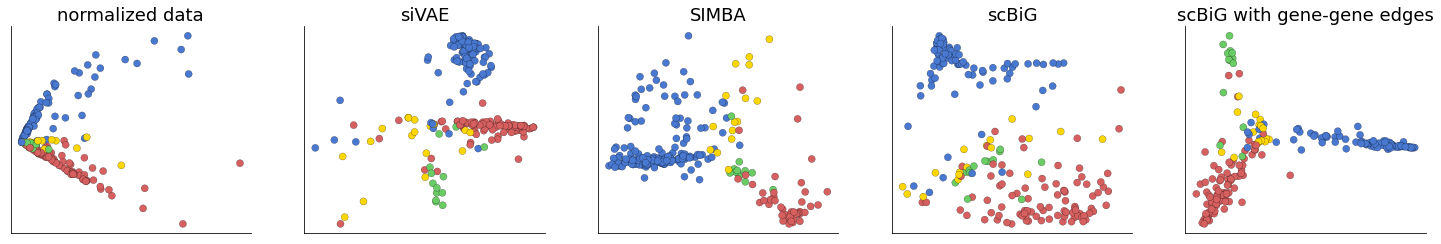

In [9]:
fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(20,3.5))
colors= ['#4878D0', 'gold', '#6ACC64','#D65F5F']
# , '#4F9D9D', '#8f8ce7','#B7B7B7','#92C5DE', '#5C90C2', '#E79796'
###PCA
model = pca(n_components=64)
X_reduction = model.fit_transform(adata.X.T)
gene_embeddings, gene_names = X_reduction['PC'].values, adata.var['feature_types'].values

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax0 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[0])
ax0.set_title("normalized data", fontsize=18)
remove_spines(ax0)

model = 'siVAE'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax1 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[1])
ax1.set_title("siVAE", fontsize=18)
remove_spines(ax1)
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())


model = 'simba'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax2 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[2])
ax2.set_title("SIMBA", fontsize=18)
remove_spines(ax2)

model = 'scBiG'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax3 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[3])
ax3.set_title("scBiG", fontsize=18)
remove_spines(ax3)



model = 'scBiG+'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax4 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[4])
ax4.set_title("scBiG with gene-gene edges", fontsize=18)
remove_spines(ax4)

# plt.delaxes(ax[2,1])


plt.legend().remove()
plt.tight_layout(h_pad=5, w_pad=5)

plt.savefig('../figures/6A/gene_embedding_{}.svg'.format(dataset),bbox_inches='tight')
plt.show()

In [10]:
dataset=datasets[1]
with h5py.File(os.path.join(dir0, 'datasets/co-expression/{}/{}.h5').format(dataset, dataset)) as data_mat:
    X = np.array(data_mat['X'])
    X = np.ceil(X).astype(np.float)
adata = sc.AnnData(X)
gene = pd.read_csv(os.path.join(dir0, 'datasets/co-expression/{}/{}_geneset.csv').format(dataset, dataset),header=0).values.squeeze()
adata.var['feature_types'] = gene
celltype = pd.read_csv(os.path.join(dir0, 'datasets/co-expression/{}/{}_celltype.csv').format(dataset, dataset),header=None).values
celltype = np.array(celltype).squeeze()
adata.var_names = gene
adata.obs['Cell Type'] = celltype
print("number of cell type: {}".format(len(np.unique(adata.obs['Cell Type']))))
print(adata)

adata = preprocess(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
adata = adata[:, adata.var.highly_variable]
print(adata)

add_geneset = add_geneset2

number of cell type: 7
AnnData object with n_obs × n_vars = 7193 × 18388
    obs: 'Cell Type'
    var: 'feature_types'
View of AnnData object with n_obs × n_vars = 7193 × 1000
    obs: 'Cell Type', 'n_genes', 'n_counts', 'cs_factor'
    var: 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [7193] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[64]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


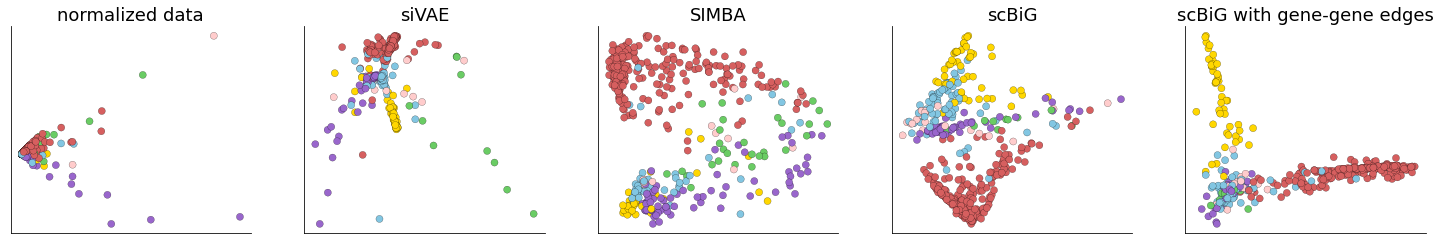

In [11]:
fig, ax = plt.subplots(1, 5, constrained_layout=True, figsize=(20,3.5))
colors= ['#9966CC', '#D65F5F','#6ACC64','#FFCCCC','#82C6E2', 'gold']
###PCA
model = pca(n_components=64)
X_reduction = model.fit_transform(adata.X.T)
gene_embeddings, gene_names = X_reduction['PC'].values, adata.var['feature_types'].values

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax0 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[0])
ax0.set_title("normalized data", fontsize=18)
remove_spines(ax0)

model = 'siVAE'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax1 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[1])
ax1.set_title("siVAE", fontsize=18)
remove_spines(ax1)
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())


model = 'simba'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax2 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[2])
ax2.set_title("SIMBA", fontsize=18)
remove_spines(ax2)

model = 'scBiG'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax3 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[3])
ax3.set_title("scBiG", fontsize=18)
remove_spines(ax3)



model = 'scBiG+'
output = np.load(os.path.join(dir0, "results/co-expression/{}_{}.npz".format(dataset, model)), allow_pickle=True)
gene_embeddings, gene_names = output['E_feature'], output['gene_name']

df_plot, dim_labels = add_geneset(gene_embeddings, gene_names)
df_plot.insert(loc=4, column='gene', value=LabelEncoder().fit_transform(df_plot.Geneset.values).astype(np.int_))
ax4 = sns.scatterplot(x=dim_labels[0], y=dim_labels[1], hue='gene', data=df_plot, legend=False,palette=colors,
                      edgecolor='black', linewidth=0.2, s=50, ax=ax[4])
ax4.set_title("scBiG with gene-gene edges", fontsize=18)
remove_spines(ax4)

# plt.delaxes(ax[2,1])


plt.legend().remove()
plt.tight_layout(h_pad=5, w_pad=5)

plt.savefig('../figures/6A/gene_embedding_{}.svg'.format(dataset),bbox_inches='tight')
plt.show()